# 0.- Desciption

This notebook solves the sources updating problem while using the scanner to get the sources observations

In [1]:
# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Module import
from IPython.display import Image
import sys
import pandas as pd

# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')


from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# 1.- **Initializing objects**

### 1.1 Create satellite

In [2]:
t_init = 0 
t_end =  t_init + 365
my_dt = 1/24/10 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)

### 1.2 Create source

In [3]:
sirio = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6)
vega = Source("vega", 279.2333, 38.78, 128.91, 201.03, 286.23, -13.9)
proxima = Source("proxima", 217.42, -62, 768.7, 3775.40, 769.33, 21.7)
sources = [sirio, vega, proxima]

### 1.3 Create scanner

In [4]:
scanner = Scanner(double_telescope=True) 

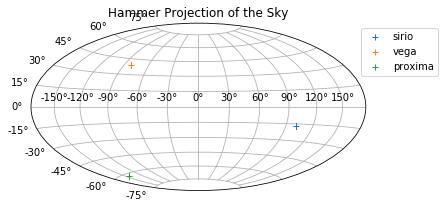

In [5]:
plt.figure()
plt.subplot(111, projection="hammer")
for i, s in enumerate(sources):
    plt.plot(ft.zero_to_two_pi_to_minus_pi_pi(np.array([s.alpha])), s.delta, '+', label=s.name)
plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)
plt.show()

# 2.- **Scan**
For the moment the scanner can only scan one source at a time

### 2.1 scan sirio

In [28]:
scanner.scan(gaia, sirio, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, sirio)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_sirio = Calc_source(obs_times=scanner.obs_times.copy(), source=sirio)

How many observation time?  35
Error:  2.2946723886109664e-14
Mean zeta: -8.3873611239454e-05


### 2.2 scan vega

In [29]:
scanner.scan(gaia, vega, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, vega)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_vega = Calc_source(obs_times=scanner.obs_times.copy(), source=vega)

How many observation time?  21
Error:  6.900036098045348e-15
Mean zeta: 0.00043744205556098335


### 2.3 scan proxima

In [30]:
scanner.scan(gaia, proxima, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, proxima)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_proxima = Calc_source(obs_times=scanner.obs_times.copy(), source=proxima)

How many observation time?  31
Error:  2.4673749633479772e-14
Mean zeta: -0.00014818263481908078


# 3.- **Some Plots**

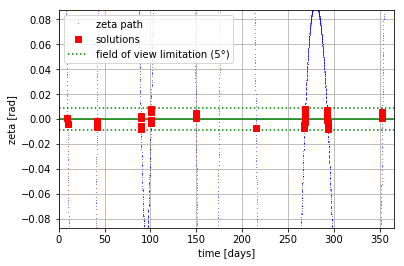

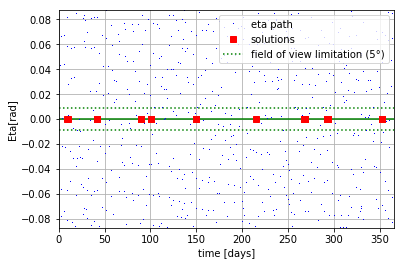

In [33]:
plot_field_angles(source=sirio, sat=gaia, obs_times=calc_sirio.obs_times, ti=t_init, tf=t_end, 
                  n=10000, limit=True, double_telescope=True);

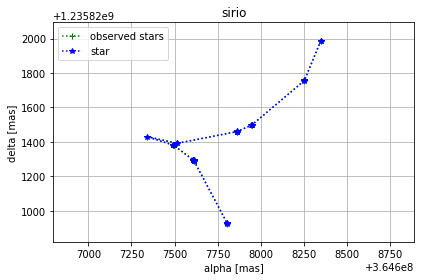

In [36]:
plot_star_trajectory_with_observations(sat=gaia, source=sirio, obs_times=calc_sirio.obs_times);

# 4.- **Use Solver with scanned sources**

In [14]:
calc_sources = [calc_sirio, calc_vega, calc_proxima]

In [15]:
def add_noise_to_calc_source(s, noise):
    """
    Adds noise to given source
    :param noise: [numoy array] of five elements, one for each parameter
    """
    s.s_params[0] += noise[0]
    s.s_params[1] += noise[1]
    s.s_params[2] += noise[2]
    s.s_params[3] += noise[3]
    s.s_params[4] += noise[4]

In [16]:
noise = np.random.rand(5)*const.rad_per_mas*5
noise[2] += 20*const.rad_per_mas
for s in calc_sources:
    add_noise_to_calc_source(s, noise)

In [17]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [18]:
Solver.reset_iterations()
Solver.iterate(10, verbosity=2)

Not resetting everything! Call again the solver instead
***** Iteration: 1 *****
Error before iteration: 3.2699467141969445e-11
Error after iteration: 2.1358057592451488e-13
***** Iteration: 2 *****
Error before iteration: 2.1358057592451488e-13
Error after iteration: 1.1671775275654675e-14
***** Iteration: 3 *****
Error before iteration: 1.1671775275654675e-14
Error after iteration: 1.657455870632767e-15
***** Iteration: 4 *****
Error before iteration: 1.657455870632767e-15
Error after iteration: 1.715497860458764e-16
***** Iteration: 5 *****
Error before iteration: 1.715497860458764e-16
Error after iteration: 1.6631493618289236e-17
***** Iteration: 6 *****
Error before iteration: 1.6631493618289236e-17
Error after iteration: 2.1837347696583565e-18
***** Iteration: 7 *****
Error before iteration: 2.1837347696583565e-18
Error after iteration: 2.2402674471729945e-19
***** Iteration: 8 *****
Error before iteration: 2.2402674471729945e-19
Error after iteration: 2.953251681816998e-20
*****

### 4.1 **See iterations**

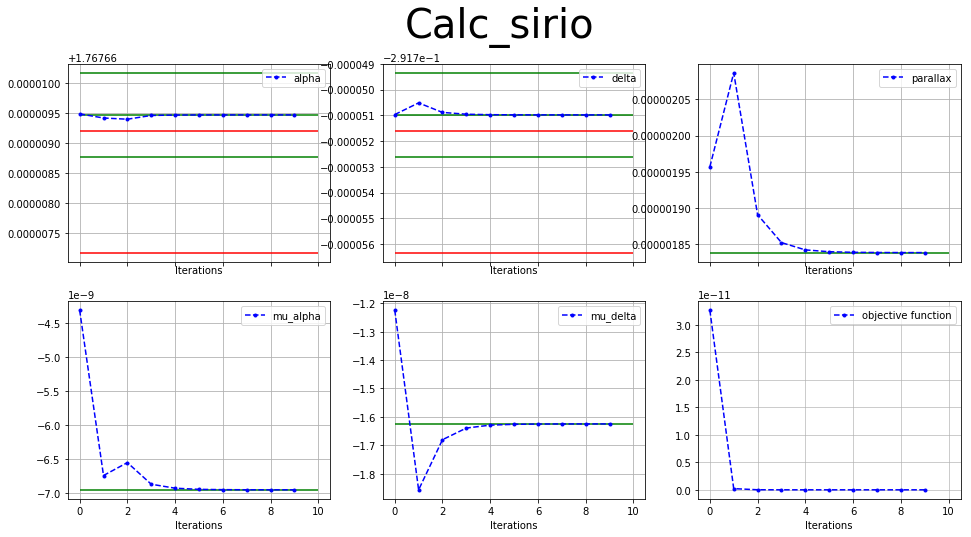

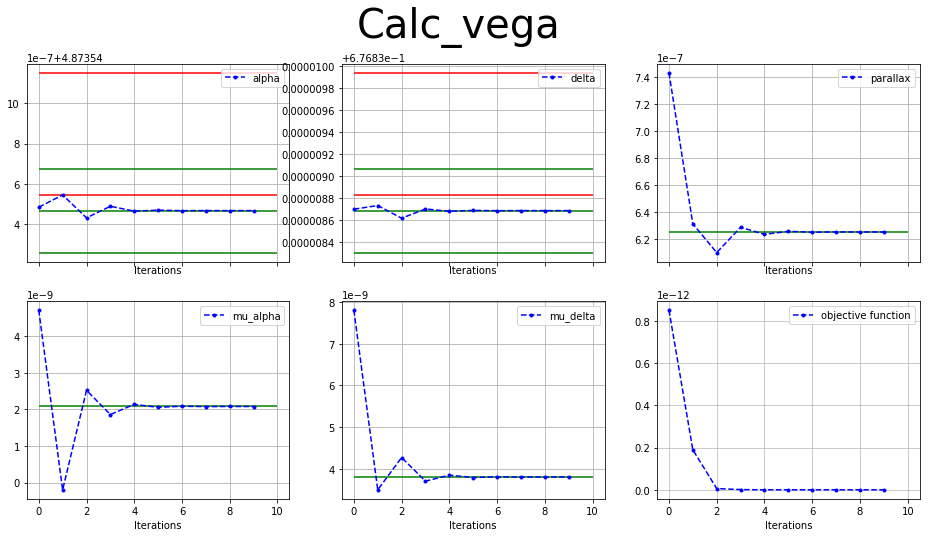

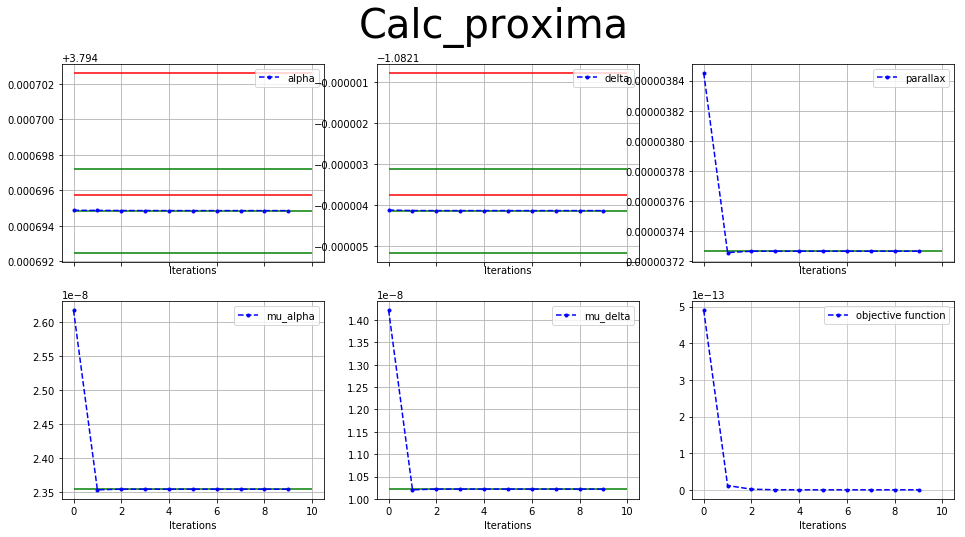

In [21]:
plot_errors_VS_iterations_per_source(Solver)

### 5.- Conclusion
We hope you found this notebook useful and easy to use! If you have any remarks, do no thesitate to contact us and if not be sure to check out the others notebooks! 